# Bookkeeping Bloqs

Bloqs for virtual operations and register reshaping.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `Allocate`
Allocate an `n` bit register.

#### Parameters
 - `dtype`: the quantum data type of the allocated register.
 - `dirty`: If true, represents a borrowing operation where allocated qubits can be dirty. 

#### Registers
 - `reg [right]`: The allocated register.


In [2]:
from qualtran.bloqs.bookkeeping import Allocate

### Example Instances

In [3]:
n = sympy.Symbol('n')
alloc = Allocate(QUInt(n))

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([alloc],
           ['`alloc`'])

### Call Graph

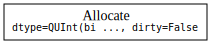

#### Counts totals:
 - `Allocate`: 1

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
alloc_g, alloc_sigma = alloc.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(alloc_g)
show_counts_sigma(alloc_sigma)

## `Free`
Free (i.e. de-allocate) a register.

The tensor decomposition assumes the register is uncomputed and is in the zero
state before getting freed. To verify that is the case, one can compute the resulting state
vector after freeing qubits and make sure it is normalized.

#### Parameters
 - `dtype`: The quantum data type of the register to be freed.
 - `dirty`: If true, represents adjoint of a borrowing operation where deallocated qubits were borrowed dirty from another part of the algorithm and must be free'd in the same dirty state. 

#### Registers
 - `reg [left]`: The register to free.


In [6]:
from qualtran.bloqs.bookkeeping import Free

### Example Instances

In [7]:
n = sympy.Symbol('n')
free = Free(QUInt(n))

#### Graphical Signature

In [8]:
from qualtran.drawing import show_bloqs
show_bloqs([free],
           ['`free`'])

### Call Graph

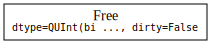

#### Counts totals:
 - `Free`: 1

In [9]:
from qualtran.resource_counting.generalizers import ignore_split_join
free_g, free_sigma = free.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(free_g)
show_counts_sigma(free_sigma)

## `Split`
Split a register of a given `dtype` into an array of `QBit`s.

A logical operation may be defined on e.g. a quantum integer, but to define its decomposition
we must operate on individual bits. `Split` can be used for this purpose. See `Join` for the
inverse operation.

#### Parameters
 - `dtype`: The quantum data type of the incoming data that will be split into an array of `QBit`s. 

#### Registers
 - `reg`: The register to be split. On its left, it is of the given data type. On the right, it is an array of `QBit()`s of shape `(dtype.num_qubits,)`.


In [10]:
from qualtran.bloqs.bookkeeping import Split

### Example Instances

In [11]:
split = Split(QUInt(4))

#### Graphical Signature

In [12]:
from qualtran.drawing import show_bloqs
show_bloqs([split],
           ['`split`'])

## `Join`
Join an array of `QBit`s into one register of type `dtype`.

#### Parameters
 - `dtype`: The quantum data type of the right (joined) register. 

#### Registers
 - `reg`: The register to be joined. On its left, it is an array of qubits. On the right, it is a register of the given data type.


In [13]:
from qualtran.bloqs.bookkeeping import Join

### Example Instances

In [14]:
join = Join(dtype=QUInt(4))

#### Graphical Signature

In [15]:
from qualtran.drawing import show_bloqs
show_bloqs([join],
           ['`join`'])

### Combining Split and Join

As a brief example, we compose split and join into an identity operation.

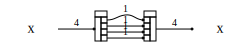

In [16]:
import attrs

@attrs.frozen
class SplitJoin(Bloq):
    n: int

    @property
    def signature(self) -> Signature:
        return Signature([Register('x', QAny(self.n))])

    def build_composite_bloq(
        self, bb: 'BloqBuilder', *, x: 'Soquet'
    ) -> Dict[str, 'Soquet']:
        xs = bb.split(x)
        x = bb.join(xs)
        return {'x': x}

split_join = SplitJoin(n=4).decompose_bloq()
show_bloq(split_join)

In the "musical score" diagrams, splits are drawn such that the `dtype` wire is terminated, and the array-of-bits wires are started; and vice-versa for join.

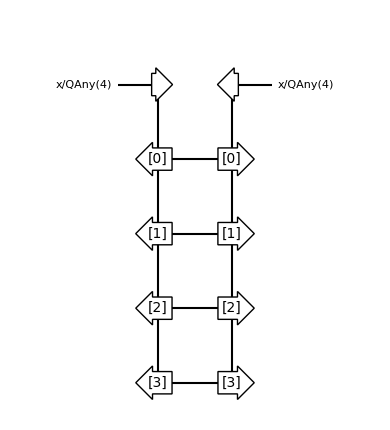

In [17]:
show_bloq(split_join, 'musical_score')

## `Partition`
Partition a generic index into multiple registers.

#### Parameters
 - `n`: The total bitsize of the un-partitioned register
 - `regs`: Registers to partition into. The `side` attribute is ignored.
 - `partition`: `False` means un-partition instead. 

#### Registers
 - `x`: the un-partitioned register. LEFT by default.
 - `[user spec]`: The registers provided by the `regs` argument. RIGHT by default.


In [18]:
from qualtran.bloqs.bookkeeping import Partition

### Example Instances

In [19]:
regs = (Register('xx', QAny(2), shape=(2, 3)), Register('yy', QAny(37)))
bitsize = sum(reg.total_bits() for reg in regs)
partition = Partition(n=bitsize, regs=regs)

#### Graphical Signature

In [20]:
from qualtran.drawing import show_bloqs
show_bloqs([partition],
           ['`partition`'])

As an example of the utility of `Partition`, we'll use the generic `TestMultiRegister` bloq as an example sub-bloq with many registers. We can wrap it in the `BlackBoxBloq` adapter defined below to abstract away the complicated signature into one register named "system".

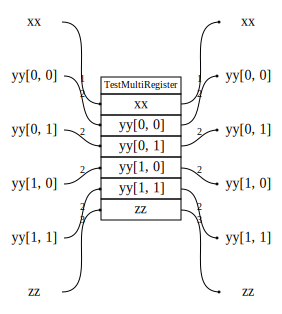

In [21]:
from qualtran.bloqs.for_testing.many_registers import TestMultiRegister

subbloq = TestMultiRegister()
show_bloq(subbloq)

In [22]:
import attrs

@attrs.frozen
class BlackBoxBloq(Bloq):
    subbloq: Bloq

    @property
    def signature(self) -> Signature:
        return Signature.build(system=self.bitsize)

    @property
    def bitsize(self):
        return sum(reg.total_bits() for reg in self.subbloq.signature)

    def build_composite_bloq(self, bb: 'BloqBuilder', system: 'SoquetT') -> Dict[str, 'Soquet']:
        bloq_regs = self.subbloq.signature
        partition = Partition(self.bitsize, bloq_regs)
        partitioned_vars = bb.add(partition, x=system)
        partitioned_vars = bb.add(
            self.subbloq, **{reg.name: sp for reg, sp in zip(bloq_regs, partitioned_vars)}
        )
        system = bb.add(
            partition.adjoint(), **{reg.name: sp for reg, sp in zip(bloq_regs, partitioned_vars)}
        )
        return {'system': system}

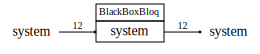

In [23]:
# The signature is now just one register named "system"
show_bloq(BlackBoxBloq(subbloq))

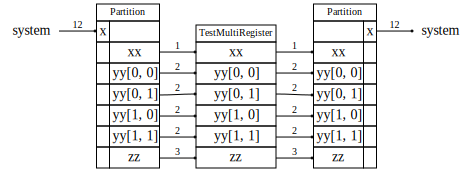

In [24]:
# The `Partition` bloq partitions the one "system" register into the quantum interface
# expected by the subbloq (and back again).
show_bloq(BlackBoxBloq(subbloq).decompose_bloq())

## `Cast`
Cast a register from one n-bit QDType to another QDType.

This re-interprets the register's data type from `inp_dtype` to `out_dtype`.

#### Parameters
 - `inp_dtype`: Input QDType to cast from.
 - `out_dtype`: Output QDType to cast to.
 - `shape`: shape of the register to cast. 

#### Registers
 - `in`: input register to cast from.
 - `out`: input register to cast to.


In [25]:
from qualtran.bloqs.bookkeeping import Cast

### Example Instances

In [26]:
from qualtran import QFxp, QInt

cast = Cast(QInt(32), QFxp(32, 32))

#### Graphical Signature

In [27]:
from qualtran.drawing import show_bloqs
show_bloqs([cast],
           ['`cast`'])

### Annotating diagrams with DTypes

Here, we see an example where the `Cast` re-interprets the input `QFxp` register as a `QUInt` so an addition can be performed. We annotate the compute graph wires with their quantum data types by using `type='dtype'` in the call to `show_bloq`.

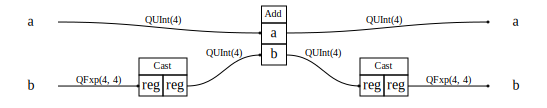

In [28]:
from qualtran.bloqs.for_testing import TestCastToFrom
show_bloq(TestCastToFrom().decompose_bloq(), type='dtype')

## `AutoPartition`
Automatically adds and undoes `Partition` of registers to match the signature of a sub-bloq.

This tool enables using a bloq in a context expecting an alternative signature that combines
registers in the bloq's signature or operates over more registers than the bloq does.
For example, it can adapt a bloq exposing multiple selection registers to a quantum interface
that expects only one unified selection register.

Wrapping in `AutoPartition` also hides splits and joins behind a level of decomposition, which
can produce more helpful circuit diagrams compared to manually splitting and joining.

#### Parameters
 - `bloq`: The sub-bloq to wrap. Its register names are used within the second items in each pair in the `partitions` argument below.
 - `partitions`: A sequence of pairs specifying each register that is exposed in the external signature of the `AutoPartition` and its relationship to the registers of `bloq`. The first element of each pair is a [`Register`](/reference/qualtran/Register.md) exposed externally. The second is a list of register names of `bloq` that concatenate to form the externally exposed register. If `bloq` does not operate on some portion (of `n` bits) of the externally exposed register, the sentinel value `Unused(n)` can be used in place of a register name.
 - `left_only`: If False, the output registers will also follow `partition`. Otherwise, the output registers will follow `bloq.signature.rights()`. This flag must be set to True if `bloq` does not have the same LEFT and RIGHT registers, as is required for the bloq to be fully wrapped on the left and right. 

#### Registers
 - `[user_spec]`: The output registers of the wrapped bloq.


In [29]:
from qualtran.bloqs.bookkeeping import AutoPartition

### Example Instances

In [30]:
from qualtran import Controlled, CtrlSpec
from qualtran.bloqs.basic_gates import Swap

bloq = Controlled(Swap(1), CtrlSpec())
auto_partition = AutoPartition(
    bloq, [(Register('x', QAny(2)), ['ctrl', 'x']), (Register('y', QAny(1)), ['y'])]
)

In [31]:
from qualtran import Controlled, CtrlSpec
from qualtran.bloqs.basic_gates import Swap
from qualtran.bloqs.bookkeeping.auto_partition import Unused

bloq = Controlled(Swap(1), CtrlSpec())
auto_partition_unused = AutoPartition(
    bloq,
    [
        (Register('x', QAny(3)), ['ctrl', 'x', Unused(1)]),
        (Register('y', QAny(1)), ['y']),
        (Register('z', QAny(2)), [Unused(2)]),
    ],
)

#### Graphical Signature

In [32]:
from qualtran.drawing import show_bloqs
show_bloqs([auto_partition, auto_partition_unused],
           ['`auto_partition`', '`auto_partition_unused`'])

### Call Graph

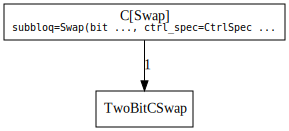

#### Counts totals:
 - `TwoBitCSwap`: 1

In [33]:
from qualtran.resource_counting.generalizers import ignore_split_join
auto_partition_g, auto_partition_sigma = auto_partition.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(auto_partition_g)
show_counts_sigma(auto_partition_sigma)

### Using `AutoPartition` to simplify diagrams

Sometimes, we want to use bloqs whose signatures don't quite match up with the signature of a bigger bloq we want to build. For example, the bloq might have a flat list of qubits whereas we have a big register, or vice versa. 

Normally, we can just split / join / partition during the decomposition and go on our way, but this leads to unsightly diagrams like this:

(<Figure size 533.333x800 with 1 Axes>, <Axes: >)

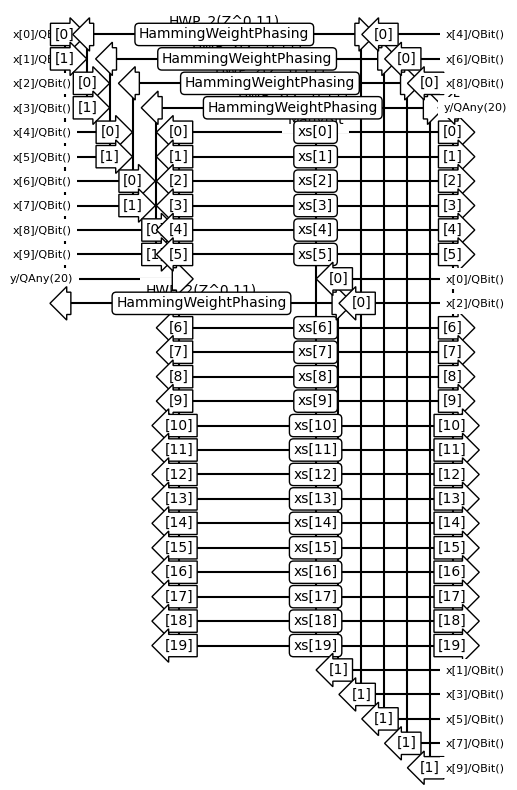

In [34]:
from functools import cached_property

from qualtran.bloqs.rotations.hamming_weight_phasing import HammingWeightPhasing
from qualtran.drawing import draw_musical_score
from qualtran.drawing.musical_score import get_musical_score_data


@attrs.frozen
class ManyBit(Bloq):
    @cached_property
    def signature(self) -> Signature:
        return Signature((Register('xs', QBit(), shape=(20,)),))


@attrs.frozen
class NotWrapped(Bloq):
    bitsize: int = 10

    @cached_property
    def signature(self) -> Signature:
        return Signature((Register('x', QBit(), shape=(self.bitsize,)), Register('y', QAny(20))))

    def build_composite_bloq(
        self, bb: BloqBuilder, x: 'SoquetT', y: 'SoquetT'
    ) -> Dict[str, 'SoquetT']:
        for i in range(5):
            two_bit = bb.join(x[i * 2 : i * 2 + 2], QUInt(2))
            two_bit = bb.add(HammingWeightPhasing(2, 0.11), x=two_bit)
            x[i * 2 : i * 2 + 2] = bb.split(two_bit)
        many_bit = bb.split(y)
        many_bit = bb.add(ManyBit(), xs=many_bit)
        return {'x': x, 'y': bb.join(many_bit)}


bloq = NotWrapped()
draw_musical_score(get_musical_score_data(bloq.decompose_bloq()))

Using the `AutoPartition` bloq, we can hide the partition/unpartition pairs behind a level of decomposition, thereby cleaning up the diagram:

(<Figure size 626.087x800 with 1 Axes>, <Axes: >)

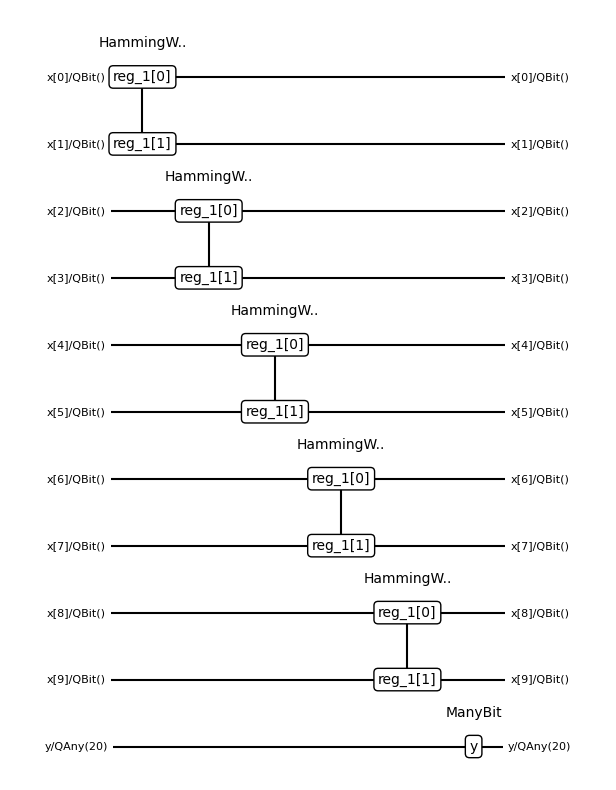

In [35]:
@attrs.frozen
class Wrapped(Bloq):
    bitsize: int = 10

    @cached_property
    def signature(self) -> Signature:
        return Signature((Register('x', QBit(), shape=(self.bitsize,)), Register('y', QAny(20))))

    def build_composite_bloq(
        self, bb: BloqBuilder, x: 'SoquetT', y: 'SoquetT'
    ) -> Dict[str, 'SoquetT']:
        for i in range(5):
            hwp = HammingWeightPhasing(2, i * 0.11)
            x[i * 2 : i * 2 + 2] = bb.add(
                AutoPartition(hwp, [(Register('reg_1', QBit(), shape=(2,)), ('x',))]),
                reg_1=x[i * 2 : i * 2 + 2],
            )
        many = ManyBit()
        b = AutoPartition(many, [(Register('y', QAny(20)), ('xs',))])
        y = bb.add(b, y=y)
        return {'x': x, 'y': y}


bloq = Wrapped()
draw_musical_score(get_musical_score_data(bloq.decompose_bloq()))

Instead of explicitly instantiating a `AutoPartition`, we can also use the utility function `BloqBuilder.add_and_partition`:

(<Figure size 626.087x800 with 1 Axes>, <Axes: >)

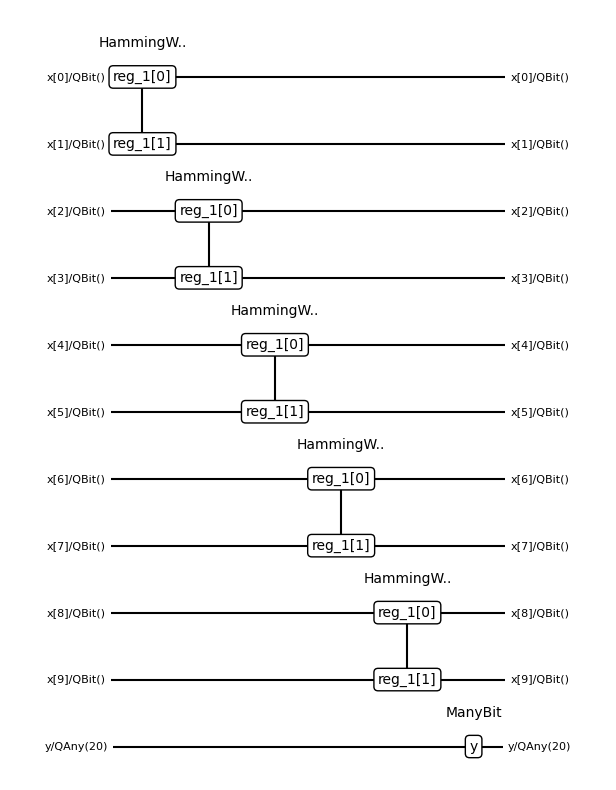

In [36]:
@attrs.frozen
class Wrapped(Bloq):
    bitsize: int = 10

    @cached_property
    def signature(self) -> Signature:
        return Signature((Register('x', QBit(), shape=(self.bitsize,)), Register('y', QAny(20))))

    def build_composite_bloq(
        self, bb: BloqBuilder, x: 'SoquetT', y: 'SoquetT'
    ) -> Dict[str, 'SoquetT']:
        for i in range(5):
            hwp = HammingWeightPhasing(2, i * 0.11)
            x[i * 2 : i * 2 + 2] = bb.add_and_partition(
                hwp, [(Register('reg_1', QBit(), shape=(2,)), ('x',))], reg_1=x[i * 2 : i * 2 + 2]
            )
        many = ManyBit()
        y = bb.add_and_partition(many, [(Register('y', QAny(20)), ('xs',))], y=y)
        return {'x': x, 'y': y}


bloq = Wrapped()
draw_musical_score(get_musical_score_data(bloq.decompose_bloq()))